In [1]:
import numpy as np
import h5py
import os
import pandas as pd

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

Populating the interactive namespace from numpy and matplotlib


In [3]:
resultsdir = '../results/cartpole_ddpg'

In [4]:
savedirs = {
    'normal_large': 'normal_buffer_large',
    'prioritized_large': 'prioritized_buffer_large',
    
    'normal_large_ema0.9': 'normal_buffer_large_ema0.9',
    'prioritized_large_ema0.9': 'prioritized_buffer_large_ema0.9',
    
    'normal_large_ema0.0': 'normal_buffer_large_ema0.0',
    'prioritized_large_ema0.0': 'prioritized_buffer_large_ema0.0',
    
    'prioritized_large_ema0.9_uniform': 'prioritized_buffer_large_ema0.9_uniform',
}
for k in savedirs:
    savedirs[k] = os.path.join(resultsdir,savedirs[k])

In [5]:
def loadHDF5(filepath):
    output = {}
    with h5py.File(filepath,'r') as f:
        for k in f:
            output[k] = np.array(f[k])
    return output

In [6]:
results = {}
for sd in savedirs:
    results[sd] = {}
    data = []
    for rd in os.listdir(savedirs[sd]):
        filepath = os.path.join(savedirs[sd],rd,'log.h5')
        
        if os.path.exists(filepath):
            data.append(loadHDF5(filepath))
            
        if len(data) > 0:
            keys = data[0].keys()
            for k in keys:
                try:
                    results[sd][k] = np.stack([v[k] for v in data])
                except:
                    pass

In [7]:
for k in sorted(results['prioritized_large'].keys()):
    print(k)

Q
action_history
beta
duration_cumulative
max_importance_weight
priorities
reward_history
sample_importance_weights
step_duration_sec
test_ep_returns
test_ep_steps


In [8]:
results[sd]['test_ep_returns'].shape

(10, 999)

In [9]:
def plot_percentiles(x,y=None,label=None):
    if y is None:
        y = x
        x = np.arange(len(y))
    p10 = np.percentile(y,1,axis=1)
    mean = y.mean(axis=1)
    p90 = np.percentile(y,99,axis=1)
    plt.fill_between(x,p10,p90,alpha=0.25)
    plt.plot(x,mean,label=label)

In [10]:
results[sd]['test_ep_steps'].shape

(10, 999)

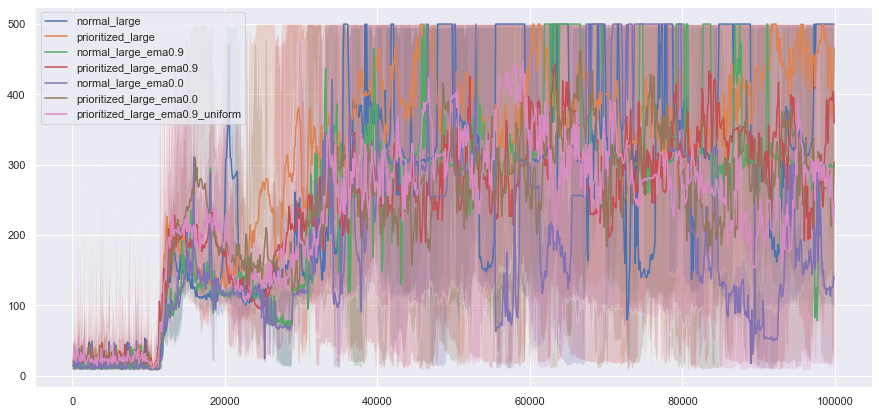

In [11]:
key = 'test_ep_returns'
plt.figure(figsize=(15,7))
for sd in results:
    plot_percentiles(results[sd]['test_ep_steps'][0],results[sd][key].T,label=sd)
_ = plt.legend()

/Users/justinmaojones/rl/env/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/justinmaojones/rl/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


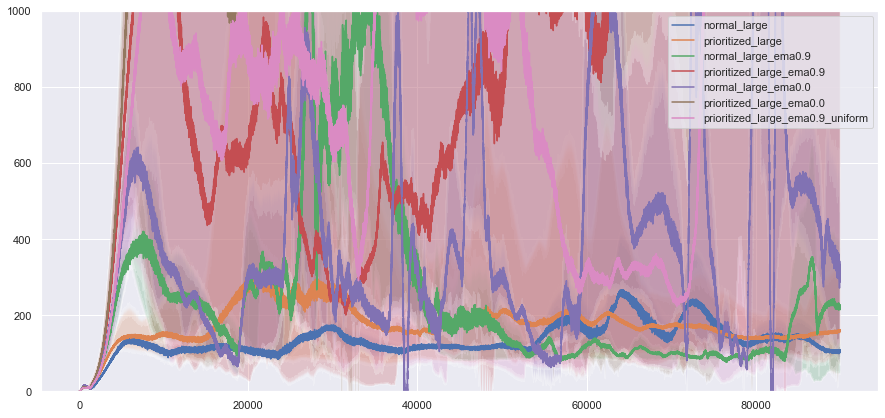

In [12]:
key = 'Q'
plt.figure(figsize=(15,7))
for sd in results:
    plot_percentiles(results[sd][key].T,label=sd)
plt.ylim(0,1000)
_ = plt.legend()

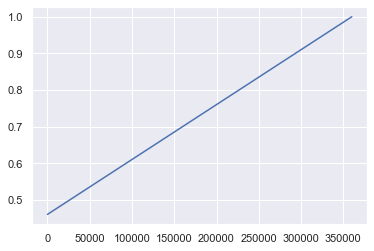

In [13]:
plt.plot(results['prioritized_large']['beta'][0])

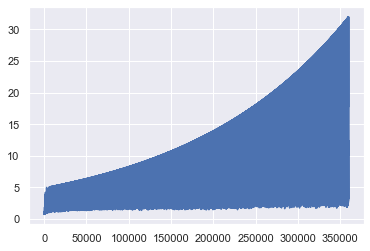

In [14]:
_ = plt.plot(results['prioritized_large']['max_importance_weight'][0])

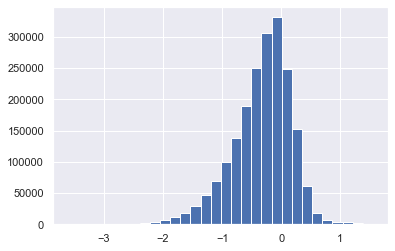

In [15]:
_ = plt.hist(np.log10(results['prioritized_large']['priorities'].ravel()),bins=30)

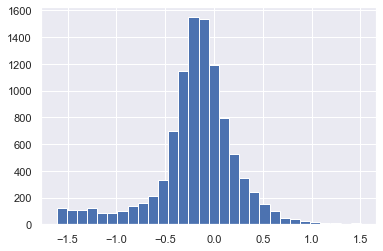

In [16]:
_ = plt.hist(np.log10(results['prioritized_large']['sample_importance_weights'].ravel()),bins=30)

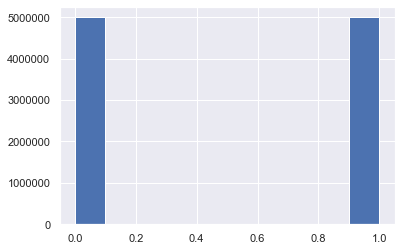

In [17]:
_ = plt.hist(results['prioritized_large']['action_history'].ravel())